## 5-2. Quantum Circuit learning

**Quantum Circuit Learning** (Quantum Circuit Learning, QCL) is an algorithm for applying quantum computers to machine learning [[1]](https://arxiv.org/abs/1803.00745).  
Like VQE (Variational Quantum Eigensolver) studied in the previous section, it is a **quantum/classical hybrid algorithm** is designed to work on **NISQ** (Noisy Intermediate-Scale Quantum Computer), a medium-scale quantum computer without error correction capability. Experiments using actual NISQ devices have already been conducted, and a paper on an actual implementation of QCL by an IBM experimental team was published in Nature in March 2019 and became a hot topic.

In the following, we first provide an overview of the algorithm and specific learning steps, and finally present an example implementation using QURI Parts.

### Overview of QCL

In recent years, deep learning has been in the limelight in the field of machine learning.  
In deep learning, a deep **neural network** is used to approximate complex functions to learn the relationship between inputs and outputs and to make predictions on new data.  

QCL is a machine learning method that replaces this neural network with a **quantum circuit**, or quantum computer. The use of quantum circuits improves the expressive power of the model because it can learn using **a large number of basis functions in an exponential manner**, taking advantage of the principle of superposition in quantum mechanics. Furthermore, it is believed that the conditions that must be satisfied by quantum circuits (unitarity) can **automatically prevent overfitting**. This is expected to further improve performance beyond that of machine learning on classical computers.   
(For details, see reference [1].)

In neural networks, the function is approximated by adjusting the weight parameter $W$ of each layer, and the concept is exactly the same in QCL.  
In other words, the quantum circuit used in QCL contains multiple "rotation gates," and the function is approximated by adjusting the rotation angle $\theta$ of these rotation gates. The specific procedure is shown below.

### Learning Procedure
1. prepare learning data $\{(x_i, y_i)\}_i$ ($x_i$ is the input data and $y_i$ is the correct data to be predicted from $x_i$ (training data) )
2. prepare a circuit  $U_{\text{in}}(x)$, which is determined by some rule from the input $x$, and set the input state $\{|\psi_{\rm in}(x_i)\rangle\}_i = \{U_{\text{in}}(x_i)|0\rangle\}_i$
3. multiply the input state by the gate $U(\theta)$ depending on the parameter $\theta$ and make the output state $\{|\psi_{\rm out}(x_i, \theta)\rangle = U(\theta)|\psi_{\rm in}(x_i)\rangle \}_i$.
4. measure some observable under the output state and obtain the measured value (e.g., the expected value of $Z$ for the first qubit $\langle Z_1\rangle = \langle \psi_{\rm out} |Z_1|\psi_{\rm out} \rangle$)
5. let $F$ be an appropriate function (sigmoid, softmax, constant times or whatever) and let $F(measurements_i)$ be the model output $y(x_i, \theta)$
6. calculate the "cost function $L(\theta)$" that represents the deviation between the correct data $\{y_i\}_i$ and the model output $\{y(x_i, \theta)\}_i$.
7. find $\theta=\theta^*$ that minimizes the cost function
8. $y(x, \theta^*)$ is the desired predictive model

(In QCL, input data $x$ is first transformed to a quantum state using $U_{\text{in}}(x)$. Then, by using a variational quantum circuit $U(\theta)$ and measurements, the output $y$ is obtained. (In the figure, the output is $\langle B(x,\theta)\rangle$) (Source: Modified from Figure 1 in reference [1])

### Implementation using QURI Parts

In the following, as a demonstration of function approximation, let's perform fitting of the sin function $y=\sin(\pi x)$ .

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
########  parameter  #############
n_qubit = 3 ##number of qubits
c_depth = 3  ## depth of circuit
time_step = 0.77  ##Elapsed time of time evolution by random Hamiltonian

## Take number_x_train points from [x_min, x_max] randomly and use them as the training data.
x_min = - 1.
x_max = 1.
num_x_train = 50

## The 1-variable function we want to learn
func_to_learn = lambda x: np.sin(x*np.pi)

##Seed of random numbers
random_seed = 0

## Initialize random number generator
np.random.seed(random_seed)

#### Prepare training data

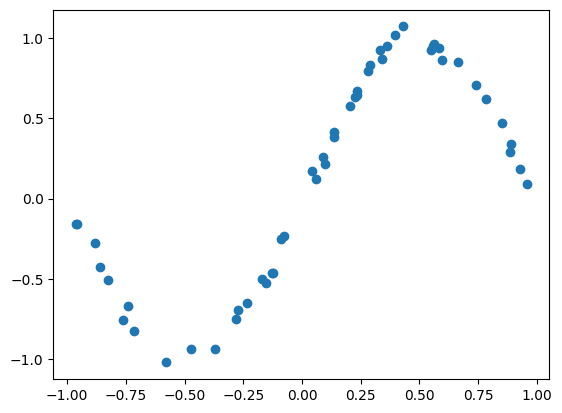

In [3]:
#### Prepare training data

x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# Add noise to a clean sin function
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

#### Composition of input state
First, create a gate $U_{\rm in}(x_i)$ to embed the input value $x_i$ into the initial state $|00\ldots0\rangle$.   
Following reference [1], by using the rotation gates $R_j^X(\theta)=e^{i\theta X_j/2}, R_j^Z(\theta)=e^{i\theta Z_j/2}$ and we define the gate as follow.<br> $U_{\rm in}(x) = \prod_j R^Z_j(\cos^{-1} x^2) R^Y_j(\sin^{-1}x)$.   
The input value $x_i$ will be converted to the quantum state $|\psi_{\rm in}(x_i)\rangle =U_{\rm in}(x_i)|00\ldots0\rangle$.

In [4]:
from quri_parts.circuit import QuantumCircuit

def U_in(x):
    """a function to create a circuit which encodes x 
    """
    U = QuantumCircuit(n_qubit)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(n_qubit):
        U.add_RY_gate(i, -angle_y)
        U.add_RZ_gate(i, -angle_z)
    
    return U

In [5]:
# sample calculation of an input state
from quri_parts.core.state import GeneralCircuitQuantumState
from quri_parts.qulacs.simulator import evaluate_state_to_vector

x = 0.1 # a sample value
evaluate_state_to_vector(
    GeneralCircuitQuantumState(n_qubit, U_in(x))
).vector

array([-6.93804351e-01+7.14937415e-01j, -3.54871219e-02-3.51340074e-02j,
       -3.54871219e-02-3.51340074e-02j,  1.77881430e-03-1.76111422e-03j,
       -3.54871219e-02-3.51340074e-02j,  1.77881430e-03-1.76111422e-03j,
        1.77881430e-03-1.76111422e-03j,  8.73809020e-05+9.00424970e-05j])

#### Configuration of variational quantum circuit $U(\theta)$
Next, we create a variational quantum circuit $U(\theta)$ to be optimized. This is done in the following three steps.

1. Generation of transverse magnetic field Ising Hamiltonian
2. Creation of rotating gate
3. Alternately combine the gates of 1. and 2. to create one large variational quantum circuit $U(\theta)$


The Hamiltonian of the transverse Ising model is as follows and is used to define the time evolution operator $U_{\text{rand}} = e^{-iHt}$.


$$
H = \sum_{j=1}^N a_j X_j + \sum_{j=1}^N \sum_{k=1}^{j-1} J_{jk} Z_j Z_k
$$

Here, the coefficients $a$, $J$ are the uniform distribution of $[-1, 1]$.

##### 1. Creation of transverse magnetic field Ising Hamiltonian
By performing time evolution using the transverse magnetic field Ising model learned in Section 4-2 and increasing the complexity (entanglement) of the quantum circuit, the expressive power of the model is enhanced. (This part can be skipped unless the reader wants to know the details.)

The Hamiltonian of the transverse Ising model is as follows and is used to define the time evolution operator $U_{\text{rand}} = e^{-iHt}$.


$$
H = \sum_{j=1}^N a_j X_j + \sum_{j=1}^N \sum_{k=1}^{j-1} J_{jk} Z_j Z_k
$$

Here, the coefficients $a$, $J$ are the uniform distribution of $[-1, 1]$.

In [6]:
from scipy.linalg import expm
from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix

def get_hamiltonian():
    ham = Operator()

    for i in range(n_qubit): ## i runs 0 to nqubit-1
        a_j = -1. + 2.*np.random.rand() ## random number between -1~1
        ham.add_term(pauli_label(f"X{i}"), a_j)

        for j in range(i-1):
            J_jk = -1. + 2.*np.random.rand() ## random number between -1~1
            ham.add_term(pauli_label(f"Z{i} Z{j}"), J_jk)
    
    return get_sparse_matrix(ham)

ham = get_hamiltonian()

time_evol_op = QuantumCircuit(n_qubit)
time_evol_op.add_UnitaryMatrix_gate(range(n_qubit), expm(-1j * ham.toarray() * time_step))

##### 2. Creation of rotating gate, 3. Configuration of $U(\theta)$


we create a variational quantum circuit $U(\theta)$ by combining time evolution by random transverse magnetic Ising model $U_{\text{rand}}$, and $j \:(=1,2,\cdots n)$ th quantum qubit multiplied by the following rotation gate

$$
U_{\text{rot}}(\theta_j^{(i)}) = R_j^X(\theta_{j1}^{(i)})R_j^Z(\theta_{j2}^{(i)})R_j^X(\theta_{j3}^{(i)})
$$

Here, $i$ is a subscript representing the layer of the quantum circuit, and $U_{\text{rand}}$ and the above rotation are repeated for a total of $d$ layers. In other words, on the whole, we compose the variational Quantum circuit as follows.
In total, there are $3$ parameters. the initital values of each $\theta$ follows uniform distribution of $[0, 2\pi]$.

Here, we use the `UnboundParametricQuantumCircuit` in QURI Parts to construct the circuit. You may find details of parametric circuit in this [QURI Parts tutorial page](https://quri-parts.qunasys.com/tutorials/parametric).

In [7]:
from quri_parts.circuit import UnboundParametricQuantumCircuit

def get_U_out() -> UnboundParametricQuantumCircuit:
    U_out = UnboundParametricQuantumCircuit(n_qubit)
    for _ in range(c_depth):
        U_out.extend(time_evol_op.gates)
        for i in range(n_qubit):
            U_out.add_ParametricRX_gate(i)
            U_out.add_ParametricRZ_gate(i)
            U_out.add_ParametricRX_gate(i)
    return U_out

U_out = get_U_out()

#### Measurement
The output of the model is the expected value of pauli Z of the 0th qubit at the output state $|\psi_{\rm out}\rangle$.
That is, $y(\theta, x_i) = \langle Z_0 \rangle = \langle \psi_{\rm out}|Z_0|\psi_{\rm out}\rangle$.

In [8]:
from quri_parts.core.operator import pauli_label, Operator
# create Observable Z_0:
# Set Observable to be 2 * Z. Factor of 2 is to widen the final range of <Z>.
# This constant must be optimized as one of the parameters in order to deal with unknown functions.
obs = Operator({pauli_label("Z0"): 2})

#### Organize a series of steps into a function
Summarize the flow up to this point and define a function that returns the predicted value $y(x_i, \theta)$ of the model from the input $x_i$.

In [9]:
from quri_parts.core.state import GeneralCircuitQuantumState
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator

estimator = create_qulacs_vector_estimator()

# A function that returns the model's predicted value y(x_i, theta) from the input x_i
def qcl_pred(x: int, U_out: QuantumCircuit) -> float:
    state = GeneralCircuitQuantumState(n_qubit)
    
    # calculate input state
    state = state.with_gates_applied(U_in(x))
    # calculate output state
    state = state.with_gates_applied(U_out)

    # the output of model
    return estimator(obs, state).value.real

#### Cost function calculation
The cost function $L(\theta)$ is the mean squared error (MSE) between the training data and the prediction data.

In [10]:
# calculate cost function L
def cost_func(theta: list[float]) -> float:
    '''
    theta: an array of length c_depth * nqubit * 3
    '''
    # update theta, the parameter of U_out
    bound_U_out = U_out.bind_parameters(theta)
    
    # calculate data of num_x_train
    y_pred = np.array([qcl_pred(x, bound_U_out) for x in x_train])
    
    # quadratic loss
    L = ((y_pred - y_train)**2).mean()
    
    return L

In [11]:
# the value of cost function with the initial value of parameter theta
random_init_param = np.random.random(U_out.parameter_count)
cost_func(random_init_param)

0.46804960352303077

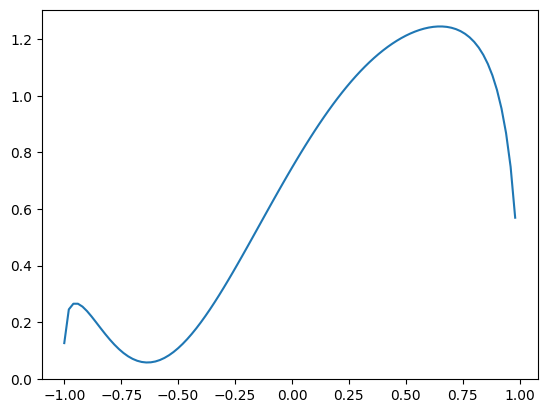

In [12]:
# graph with the initial value of parameter theta
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out.bind_parameters(random_init_param)) for x in xlist]
plt.plot(xlist, y_init)

#### Learning (optimize with scipy.optimize.minimize)
Finally, the preparation is over, and it's finally time to study. Here, for simplicity, the optimization is performed using the Nelder-Mead method, which does not require a gradient formula. When using an optimization method that uses gradients (e.g. BFGS method), a convenient formula for calculating gradients is introduced in Reference [[1]](https://arxiv.org/abs/1803.00745).

In [28]:
from scipy.optimize import minimize

In [34]:
result = minimize(cost_func, random_init_param, method='Nelder-Mead') 

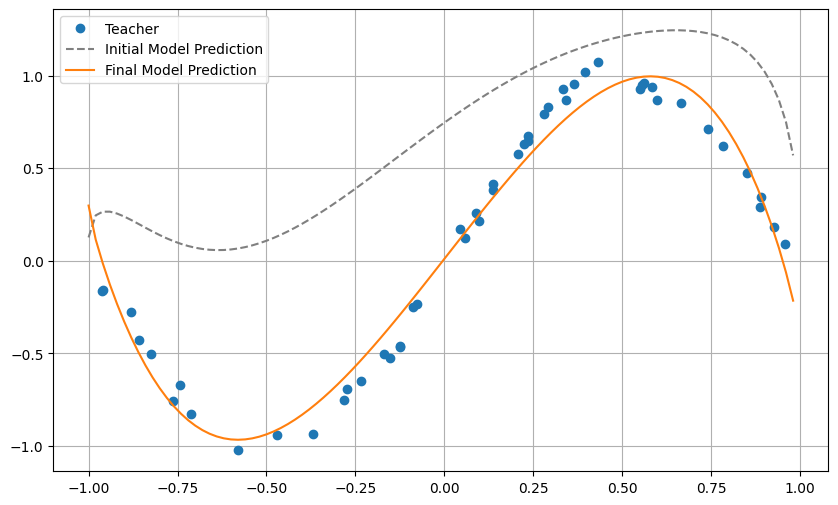

In [35]:
# plot
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# training data
plt.plot(x_train, y_train, "o", label='Teacher')

# Graph under initial value of parameter θ
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# prediction of model
y_pred = np.array([qcl_pred(x, U_out.bind_parameters(result.x)) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.grid()
plt.show()

It can be seen that the approximation of the sin function is indeed successful.<br>
Here, we dealt with a very simple task of approximating a function with one-dimensional input and output, but it can be extended to approximation of functions with multi-dimensional inputs and outputs and classification problems.
Aspiring readers are encouraged to tackle classification problems of the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), which is one of the representative machine learning datasets.

##### Optimization loop with QURI Parts

The minimization procedure can also be done with QURI Parts. You may check out QURI Parts' lecture on [Variational Algorithm](https://quri-parts.qunasys.com/tutorials/variational). Here, we provide an example on how to do QCL with QURI Parts. To do this we need to implement the gradient function as well as the optimization loop on our own.

In [16]:
from typing import Callable, Sequence
from quri_parts.algo.optimizer import OptimizerStatus, OptimizerState, Optimizer
from quri_parts.qulacs.estimator import create_qulacs_vector_concurrent_parametric_estimator

from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.estimator.gradient import create_numerical_gradient_estimator
from quri_parts.circuit import UnboundParametricQuantumCircuit


def grad_func(theta: Sequence[float]) -> Sequence[float]:
    """Gradient of the cost function with respect to the circuit parameters
    theta.
    """
    parmam_estimator = create_qulacs_vector_concurrent_parametric_estimator()
    grad_estimator = create_numerical_gradient_estimator(parmam_estimator, 1e-8)
    estimator = create_qulacs_vector_estimator()
    
    grads = []
    for x, y in zip(x_train, y_train):
        param_circuit = UnboundParametricQuantumCircuit(n_qubit)
        param_circuit.extend(U_in(x))
        param_circuit.extend(U_out)
        param_state = ParametricCircuitQuantumState(n_qubit, param_circuit)
        
        circuit_grad = np.array(grad_estimator(obs, param_state, theta).values).real
        y_pred = estimator(obs, param_state.bind_parameters(theta)).value.real
        
        grads.append(- 2 * (y - y_pred) * circuit_grad)
    
    return np.array(grads).sum(axis=0)/len(x_train)


def quantum_circuit_learning(
    init_params: Sequence[float],
    cost_fn: Callable[[Sequence[float]], float],
    grad_fn: Callable[[Sequence[float]], Sequence[float]],
    optimizer: Optimizer
) -> OptimizerState:
    """Optimization loop for performing quantum circuit learning.
    """
    opt_state = optimizer.get_init_state(init_params)
    while True:
        opt_state = optimizer.step(opt_state, cost_fn, grad_fn)
        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            print("Optimizer converged")
            break
    return opt_state

In [17]:
from quri_parts.algo.optimizer import LBFGS
result_qp = quantum_circuit_learning(random_init_param, cost_func, grad_func, LBFGS())

Optimizer converged


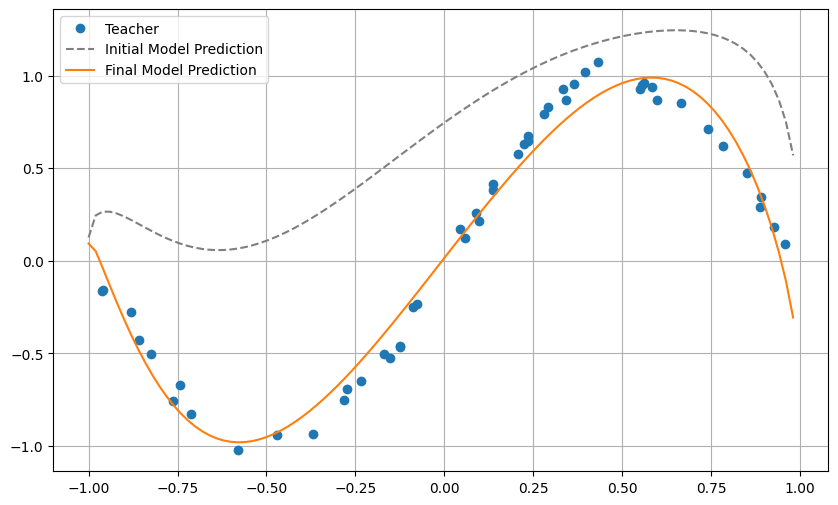

In [18]:
# plot
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# training data
plt.plot(x_train, y_train, "o", label='Teacher')

# Graph under initial value of parameter θ
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# prediction of model
y_pred = np.array([qcl_pred(x, U_out.bind_parameters(result_qp.params)) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()    
plt.grid()
plt.show()

##### Perform Quantum Circuit Learning on a real quantum computer

Up to this point, we are doing everything with a simulator. However, QURI Parts also allow us to easily submit our algorithm onto real devices by changing the simulator's estimator to a backend estimator. Please check out the QURI Parts tutorial on [Sampling Simulation](https://quri-parts.qunasys.com/tutorials/sampling_simulation) and [Sampling on Real Devices](https://quri-parts.qunasys.com/tutorials/sampling_backends/).

We first demonstrate how to create a sampler from a real device

In [6]:
from quri_parts.core.estimator.sampling import (
    create_sampling_estimator,
    create_sampling_concurrent_estimator
)
from quri_parts.core.sampling import create_concurrent_sampler_from_sampling_backend
from quri_parts.core.sampling.shots_allocator import create_proportional_shots_allocator
from quri_parts.core.estimator.gradient import create_parameter_shift_gradient_estimator
from quri_parts.core.estimator import Estimate
from quri_parts.core.measurement import bitwise_commuting_pauli_measurement
from quri_parts.qiskit.backend import QiskitRuntimeSamplingBackend

from qiskit_ibm_runtime import QiskitRuntimeService

# Activate IBM Quantum account
account = QiskitRuntimeService.saved_accounts()['default-ibm-quantum']
service = QiskitRuntimeService(**account)

# Create the sampling backend and sampler
sampling_backend = QiskitRuntimeSamplingBackend(
    backend=service.backend("ibmq_qasm_simulator"),
    service=service,
)
ibmq_concurrent_sampler = create_concurrent_sampler_from_sampling_backend(sampling_backend)

Using a real device is often very time consuming. So, we use the qulacs sampling simulator for demonstration. If you wish to run on a real device, you may directly replace `qulacs_concurrent_sampler` below with the `ibmq_concurrent_sampler` created above.

In [20]:
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler

qulacs_concurrent_sampler = create_qulacs_vector_concurrent_sampler()

We are now ready to construct a sampling estimator that estimates expectation values based on sampling experiments.

In [23]:
# Create the sampling estimators
n_shots = int(1e6)
shots_allocator = create_proportional_shots_allocator()
measurement_factory = bitwise_commuting_pauli_measurement
sampling_estimator = create_sampling_estimator(
    n_shots, qulacs_concurrent_sampler, measurement_factory, shots_allocator
)
concurrent_sampling_estimator = create_sampling_concurrent_estimator(
    n_shots, qulacs_concurrent_sampler, measurement_factory, shots_allocator
)


# Create the sampling gradient estimators
def concurrent_param_sampling_estimator(
    estimatable: Operator,
    param_state: ParametricCircuitQuantumState,
    params: Sequence[Sequence[float]]
) -> Estimate[complex]:
    return concurrent_sampling_estimator(
        [estimatable]*len(params),
        [param_state.bind_parameters(param) for param in params]
    )

sampling_grad_estimator = create_parameter_shift_gradient_estimator(
    concurrent_param_sampling_estimator
)

We also need to rewrite out cost function and gradient function in order for us to incorporate the sampling estimators we just created. Note that the codes are almost the same as the simulator codes. Only the estimators are replaced.

In [24]:
def sampling_cost_func(theta: list[float]) -> float:
    """cost function evaluated based on sampling estimation.
    """
    y_preds = []
    for x in x_train:
        state = GeneralCircuitQuantumState(n_qubit)
        state = state.with_gates_applied(U_in(x))
        state = state.with_gates_applied(U_out.bind_parameters(theta))
        y_preds.append(sampling_estimator(obs, state).value)

    # quadratic loss
    return np.mean((np.array(y_preds) - y_train)**2)


def sampling_grad_func(theta: Sequence[float]) -> Sequence[float]:
    """Gradient of the cost function with respect to the circuit parameters
    theta. Computation done by sampling estimation.
    """

    grads = []
    for x, y in zip(x_train, y_train):
        param_circuit = UnboundParametricQuantumCircuit(n_qubit)
        param_circuit.extend(U_in(x))
        param_circuit.extend(U_out)
        param_state = ParametricCircuitQuantumState(n_qubit, param_circuit)
        
        circuit_grad = np.array(sampling_grad_estimator(obs, param_state, theta).values).real
        y_pred = sampling_estimator(obs, param_state.bind_parameters(theta)).value.real
        
        grads.append(- 2 * (y - y_pred) * circuit_grad)
    
    return np.array(grads).sum(axis=0)/len(x_train)


Finally, we are ready to run QCL with sampling estimators.

In [25]:
from quri_parts.algo.optimizer import LBFGS
sampling_result_qp = quantum_circuit_learning(
    random_init_param,
    sampling_cost_func,
    sampling_grad_func,
    LBFGS()
)

Optimizer failed


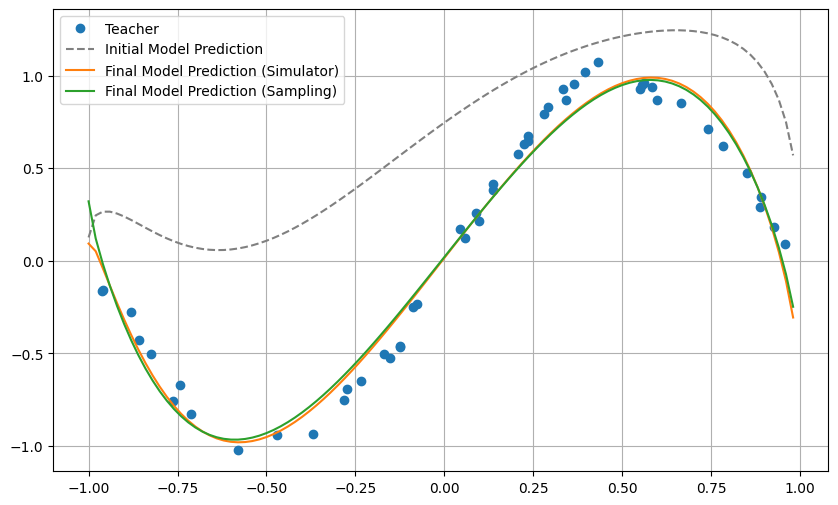

In [26]:
# plot
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# training data
plt.plot(x_train, y_train, "o", label='Teacher')

# Graph under initial value of parameter θ
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# prediction of model
exact_y_pred = np.array([qcl_pred(x, U_out.bind_parameters(result_qp.params)) for x in xlist])
sampling_y_pred = np.array([qcl_pred(x, U_out.bind_parameters(sampling_result_qp.params)) for x in xlist])
plt.plot(xlist, exact_y_pred, label='Final Model Prediction (Simulator)')
plt.plot(xlist, sampling_y_pred, label='Final Model Prediction (Sampling)')

plt.legend()
plt.grid()
plt.show()

### Reference
[1] K. Mitarai, M. Negoro, M. Kitagawa, and K. Fujii, “Quantum circuit learning”, [Phys. Rev. A 98, 032309 (2018)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.032309), arXiv：https://arxiv.org/abs/1803.00745  
[2] V. Havlicek _et al._ , “Supervised learning with quantum-enhanced feature spaces”, [Nature 567, 209–212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), arXiv：https://arxiv.org/abs/1804.11326